In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# ML libs (import later inside parts if you want)
import tensorflow as tf
from tensorflow import keras

print("Python:", os.sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)


Python: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
TensorFlow: 2.20.0


In [2]:
# load function (limit samples for first test)
import cv2, glob

def load_malaria_images(data_dir, img_size=(128,128), max_samples=500):
    images = []
    labels = []
    classes = [('Parasitized',1), ('Uninfected',0)]
    for cls,lab in classes:
        p = os.path.join(data_dir, cls)
        files = glob.glob(os.path.join(p, '*'))
        files = files[:max_samples]
        print(f"Found {len(files)} files in {p}")
        for f in files:
            try:
                im = cv2.imread(f)
                if im is None:
                    # skip unreadable files
                    continue
                im = cv2.resize(im, img_size)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                im = im.astype('float32') / 255.0
                images.append(im)
                labels.append(lab)
            except Exception as e:
                print("Error:", f, e)
    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)
    # shuffle
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]
    return X, y

# Run a quick load: update path if dataset is somewhere else
DATA_DIR = 'data/cell_images'  # put Kaggle 'cell_images' here
X, y = load_malaria_images(DATA_DIR, img_size=(128,128), max_samples=200)
print("Loaded shapes:", X.shape, y.shape)
print("Class counts:", np.bincount(y))


Found 200 files in data/cell_images\Parasitized
Found 200 files in data/cell_images\Uninfected
Loaded shapes: (400, 128, 128, 3) (400,)
Class counts: [200 200]


In [3]:
from tensorflow.keras import layers, models

def create_malaria_cnn_small(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(16,(3,3),activation='relu',padding='same',input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(32,(3,3),activation='relu',padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = create_malaria_cnn_small()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,102,369 (8.02 MB)

 Trainable params: 2,102,369 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Cell 6: compile and quick fit
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=3, batch_size=16, validation_data=(X_val,y_val))


Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.4656 - loss: 0.7402 - val_accuracy: 0.5000 - val_loss: 0.6887
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6281 - loss: 0.6579 - val_accuracy: 0.6375 - val_loss: 0.6619
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7031 - loss: 0.5891 - val_accuracy: 0.6625 - val_loss: 0.6281


In [5]:
# Cell 7: save and quick predict
model.save('models/malaria_test_small.h5')
print("Saved model: models/malaria_test_small.h5")

# test single prediction
sample = X_val[0:1]
prob = model.predict(sample)[0][0]
print("Pred prob:", prob, "Label:", y_val[0])


Saved model: models/malaria_test_small.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Pred prob: 0.5328328 Label: 0


In [6]:
# Cell 8: load and clean reported_numbers.csv
csv_path = 'data/reported_numbers.csv'  # put that file here

df = pd.read_csv(csv_path)
print("Raw columns:", df.columns.tolist())

# normalize column names (strip spaces and lower)
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('#', '').str.lower()
print("Cleaned columns:", df.columns.tolist())

# show sample rows and countries
print(df.head())
print("Unique countries sample:", df['country'].unique()[:20])


Raw columns: ['Country', 'Year', 'No. of cases', 'No. of deaths', 'WHO Region']
Cleaned columns: ['country', 'year', 'no._of_cases', 'no._of_deaths', 'who_region']
       country  year  no._of_cases  no._of_deaths             who_region
0  Afghanistan  2017      161778.0           10.0  Eastern Mediterranean
1      Algeria  2017           0.0            0.0                 Africa
2       Angola  2017     3874892.0        13967.0                 Africa
3    Argentina  2017           0.0            1.0               Americas
4      Armenia  2017           0.0            NaN                 Europe
Unique countries sample: ['Afghanistan' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Azerbaijan'
 'Bangladesh' 'Belize' 'Benin' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Botswana' 'Brazil' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia'
 'Cameroon' 'Central African Republic' 'Chad']


In [7]:
# find column containing 'case' (robust)
cases_col = [c for c in df.columns if 'case' in c]
print("cases_col:", cases_col)

cases_col: ['no._of_cases']


In [8]:
# Cell 9: build time series for a chosen country
country = 'India'  # change as needed
# attempt common names variations
if country not in df['country'].values:
    # show top matches
    print("Country not found, show unique sample (first 50):")
    print(df['country'].unique()[:50])
else:
    # choose the cases column robustly
    cases_col = [c for c in df.columns if 'case' in c][0]
    print("Using cases column:", cases_col)
    country_df = df[df['country']==country].copy()
    country_df = country_df.sort_values('year')
    # convert year to datetime index
    country_df['date'] = pd.to_datetime(country_df['year'].astype(int), format='%Y')
    country_df.set_index('date', inplace=True)
    ts = country_df[cases_col].astype(float)
    print("Time series length:", len(ts))
    display(ts.head(), ts.tail())


Using cases column: no._of_cases
Time series length: 18


date
2000-01-01    2031790.0
2001-01-01    2085484.0
2002-01-01    1841227.0
2003-01-01    1869403.0
2004-01-01    1915363.0
Name: no._of_cases, dtype: float64

date
2013-01-01     881730.0
2014-01-01    1102205.0
2015-01-01    1169261.0
2016-01-01    1087285.0
2017-01-01     844558.0
Name: no._of_cases, dtype: float64

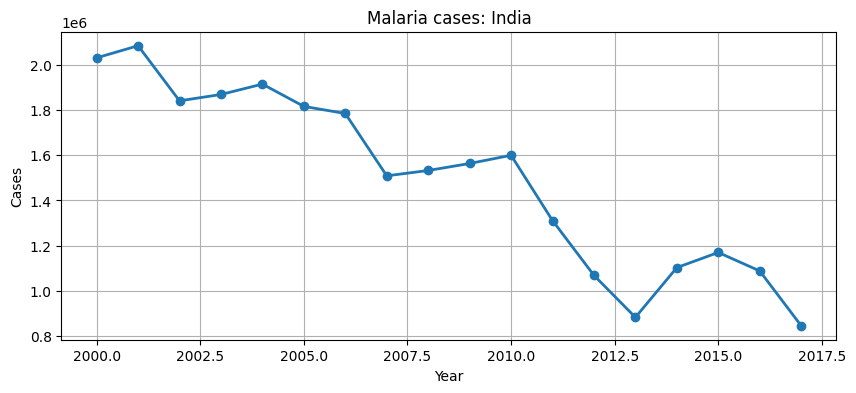

In [9]:
# Cell 10: quick EDA plot
plt.figure(figsize=(10,4))
plt.plot(ts.index.year, ts.values, marker='o', linewidth=2)
plt.title(f'Malaria cases: {country}')
plt.xlabel('Year'); plt.ylabel('Cases'); plt.grid(True)
plt.show()


In [10]:
# Cell 11: ADF test
from statsmodels.tsa.stattools import adfuller
adf = adfuller(ts.dropna())
print("ADF stat:", adf[0], "pval:", adf[1])
if adf[1] < 0.05:
    print("Series stationary")
else:
    print("Series non-stationary; difference once")
    ts_diff = ts.diff().dropna()


ADF stat: 0.0684013744328078 pval: 0.9638363036135984
Series non-stationary; difference once


In [11]:
# Cell 12: train/test split
split_idx = int(len(ts) * 0.8)
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]
print("Train len:", len(train), "Test len:", len(test))


Train len: 14 Test len: 4


In [12]:
# Cell 13: ARIMA train (use short)
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
try:
    arima_order = (1,1,1)
    model = ARIMA(train, order=arima_order)
    fitted = model.fit()
    print("ARIMA trained; AIC:", fitted.aic)
except Exception as e:
    print("ARIMA failed:", e)
    # try fallback
    model = ARIMA(train, order=(2,1,2))
    fitted = model.fit()
    print("Fallback ARIMA trained; AIC:", fitted.aic)


ARIMA trained; AIC: 353.205036690378


e:\malaria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
e:\malaria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
e:\malaria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [13]:
# Cell 14: forecast for test and future
from sklearn.metrics import mean_absolute_error, mean_squared_error

# forecast for test range
n_test = len(test)
test_pred = fitted.forecast(steps=n_test)
mae = mean_absolute_error(test, test_pred)
rmse = np.sqrt(mean_squared_error(test, test_pred))
print("MAE:", mae, "RMSE:", rmse)

# future forecast (5 years)
future_steps = 5
future_forecast = fitted.forecast(steps=future_steps)
print("Future forecast:", future_forecast)


MAE: 192443.02547214497 RMSE: 216284.21603212817
Future forecast: 2014-01-01    870195.314898
2015-01-01    875127.224718
2016-01-01    873018.477556
2017-01-01    873920.119061
2018-01-01    873534.602287
Freq: YS-JAN, Name: predicted_mean, dtype: float64


Saved ARIMA: models/malaria_forecast_arima.pkl


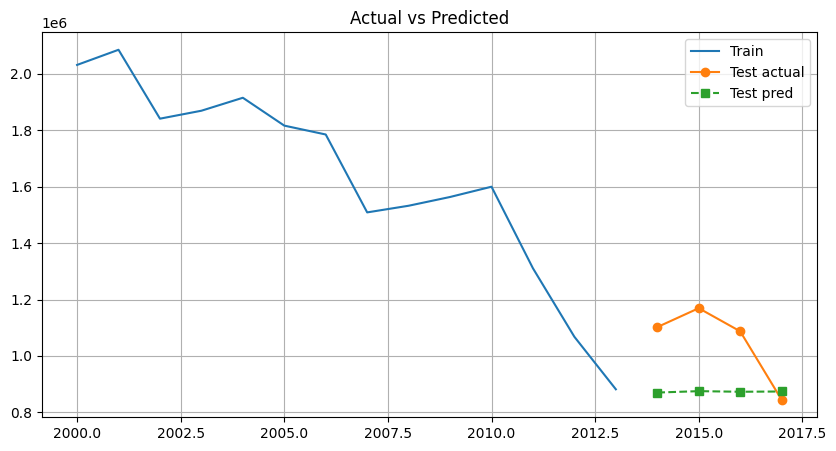

In [14]:
# Cell 15: save model & plots
joblib.dump(fitted, 'models/malaria_forecast_arima.pkl')
print("Saved ARIMA:", 'models/malaria_forecast_arima.pkl')

# plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(train.index.year, train, label='Train')
plt.plot(test.index.year, test, 'o-', label='Test actual')
plt.plot(test.index.year, test_pred, 's--', label='Test pred')
plt.legend(); plt.grid(True)
plt.title('Actual vs Predicted')
plt.show()
